# Quantum Machine Learning for Classification Task

**Demonstrations on some common setups and techniques**

## Overview

We use the fashion-MNIST dataset to set up a binary classification task, we will try different encoding schemes for the inputs and apply possible classical post-processing on the quantum outputs to enhance the classification accuracy. In this tutorial, we stick to the TensorFlow backend and try to consistently use the **Keras interface** provided by tensorcircuit for quantum functions, where we can magically turn a quantum function into a Keras layer.

In [1]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorcircuit as tc

K = tc.set_backend("tensorflow")

## Dataset and Pre-processing

We first load the fashion-mnist dataset and differentiation between T-shirt (0) and Trouser (1).

In [2]:
(x_train, y_train), (x_test, y_test) = tc.templates.dataset.mnist_pair_data(
    0, 1, loader=tf.keras.datasets.fashion_mnist
)

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12000, 28, 28, 1), (12000,), (2000, 28, 28, 1), (2000,))

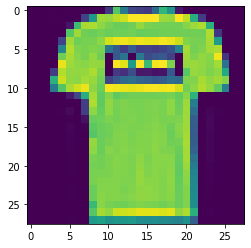

In [4]:
plt.imshow(x_train[0])

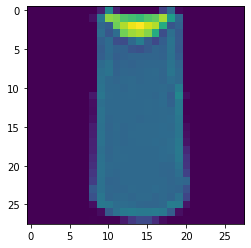

In [5]:
plt.imshow(x_train[1])

## Amplitude Encoding

In [6]:
x_train = tf.image.pad_to_bounding_box(x_train, 2, 2, 32, 32)
x_test = tf.image.pad_to_bounding_box(x_test, 2, 2, 32, 32)

In [7]:
batched_ae = K.vmap(tc.templates.dataset.amplitude_encoding, vectorized_argnums=0)

In [8]:
x_train_q = batched_ae(x_train, 10)
x_test_q = batched_ae(x_test, 10)

In [9]:
n = 10
blocks = 3


def qml(x, weights):
    c = tc.Circuit(n, inputs=x)
    for j in range(blocks):
        for i in range(n):
            c.rx(i, theta=weights[j, i, 0])
            c.rz(i, theta=weights[j, i, 1])
        for i in range(n - 1):
            c.exp1(i, i + 1, theta=weights[j, i, 2], unitary=tc.gates._zz_matrix)
    outputs = K.stack(
        [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]
        + [K.real(c.expectation([tc.gates.x(), [i]])) for i in range(n)]
    )
    outputs = K.reshape(outputs, [-1])
    return K.sigmoid(K.sum(outputs))


qml_layer = tc.keras.QuantumLayer(qml, weights_shape=[blocks, n, 3])

In [10]:
model = tf.keras.Sequential([qml_layer])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train_q, y_train, batch_size=32, epochs=3, validation_split=0.8)

Epoch 1/3
75/75 [==============================] - 85s 559ms/step - loss: 0.6217 - binary_accuracy: 0.7667 - val_loss: 0.3990 - val_binary_accuracy: 0.9620
Epoch 2/3
75/75 [==============================] - 14s 185ms/step - loss: 0.3701 - binary_accuracy: 0.9571 - val_loss: 0.3421 - val_binary_accuracy: 0.9507
Epoch 3/3
75/75 [==============================] - 14s 185ms/step - loss: 0.3252 - binary_accuracy: 0.9542 - val_loss: 0.3030 - val_binary_accuracy: 0.9540


## Classical Post-processing

We attached one Linear layer after the quantum outputs to enhance the capacity of the machine learning model as a quantum-neural hybrid machine learning approach.

In [11]:
def qml(x, weights):
    c = tc.Circuit(n, inputs=x)
    for j in range(blocks):
        for i in range(n):
            c.rx(i, theta=weights[j, i, 0])
            c.rz(i, theta=weights[j, i, 1])
        for i in range(n - 1):
            c.exp1(i, i + 1, theta=weights[j, i, 2], unitary=tc.gates._zz_matrix)
    outputs = K.stack(
        [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]
        + [K.real(c.expectation([tc.gates.x(), [i]])) for i in range(n)]
    )
    outputs = K.reshape(outputs, [-1])
    return outputs


qml_layer = tc.keras.QuantumLayer(qml, weights_shape=[blocks, n, 3])

inputs = tf.keras.Input(shape=(2 ** n), dtype=tf.complex64)
measurements = qml_layer(inputs)
output = tf.keras.layers.Dense(1, activation="sigmoid")(measurements)
model = tf.keras.Model(inputs=inputs, outputs=output)

In [12]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train_q, y_train, batch_size=32, epochs=3, validation_split=0.8)

Epoch 1/3
75/75 [==============================] - 71s 508ms/step - loss: 0.5140 - binary_accuracy: 0.8841 - val_loss: 0.3617 - val_binary_accuracy: 0.9521
Epoch 2/3
75/75 [==============================] - 14s 182ms/step - loss: 0.2803 - binary_accuracy: 0.9421 - val_loss: 0.2093 - val_binary_accuracy: 0.9506
Epoch 3/3
75/75 [==============================] - 15s 200ms/step - loss: 0.2057 - binary_accuracy: 0.9437 - val_loss: 0.1795 - val_binary_accuracy: 0.9483


## PCA Embedding

Amplitude encoding is difficult to implement on real quantum hardware, we here instead consider another way for data input, where only a single qubit rotation is involved. To compress the input data such that it can fit into a small circuit, PCA dimension reduction is required.

In [13]:
x_train_r = PCA(10).fit_transform(x_train.numpy().reshape([-1, 32 * 32]))

In [14]:
x_train_r.shape  # we now has 10-d vector compression for each figure

(12000, 10)

In [15]:
def qml(x, weights):
    c = tc.Circuit(n)
    for i in range(10):
        c.rx(i, theta=x[i])  # loading the data
    for j in range(blocks):
        for i in range(n):
            c.rx(i, theta=weights[j, i, 0])
            c.rz(i, theta=weights[j, i, 1])
        for i in range(n - 1):
            c.exp1(i, i + 1, theta=weights[j, i, 2], unitary=tc.gates._zz_matrix)
    outputs = K.stack(
        [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]
        + [K.real(c.expectation([tc.gates.x(), [i]])) for i in range(n)]
    )
    outputs = K.reshape(outputs, [-1])
    return K.sigmoid(K.sum(outputs))


qml_layer = tc.keras.QuantumLayer(qml, weights_shape=[blocks, n, 3])

In [16]:
model = tf.keras.Sequential([qml_layer])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train_r, y_train, batch_size=32, epochs=3, validation_split=0.8)

Epoch 1/3
75/75 [==============================] - 71s 447ms/step - loss: 0.7993 - binary_accuracy: 0.6996 - val_loss: 0.3026 - val_binary_accuracy: 0.8829
Epoch 2/3
75/75 [==============================] - 6s 80ms/step - loss: 0.2745 - binary_accuracy: 0.8983 - val_loss: 0.2559 - val_binary_accuracy: 0.9087
Epoch 3/3
75/75 [==============================] - 6s 83ms/step - loss: 0.2513 - binary_accuracy: 0.9167 - val_loss: 0.2385 - val_binary_accuracy: 0.9187


## Data Re-uploading

By loading the PCA embedding data multiple times in the VQA, we may further increase the accuracy of the model.

In [17]:
def qml(x, weights):
    c = tc.Circuit(n)
    for j in range(blocks):
        for i in range(10):
            c.ry(i, theta=x[i])  # loading the data repetitively
        for i in range(n):
            c.rx(i, theta=weights[j, i, 0])
            c.rz(i, theta=weights[j, i, 1])
        for i in range(n - 1):
            c.exp1(i, i + 1, theta=weights[j, i, 2], unitary=tc.gates._zz_matrix)
    outputs = K.stack(
        [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]
        + [K.real(c.expectation([tc.gates.x(), [i]])) for i in range(n)]
    )
    outputs = K.reshape(outputs, [-1])
    return K.sigmoid(K.sum(outputs))


qml_layer = tc.keras.QuantumLayer(qml, weights_shape=[blocks, n, 3])

In [19]:
model = tf.keras.Sequential([qml_layer])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train_r, y_train, batch_size=32, epochs=3, validation_split=0.8)

Epoch 1/3
75/75 [==============================] - 20s 146ms/step - loss: 0.2506 - binary_accuracy: 0.9070 - val_loss: 0.2271 - val_binary_accuracy: 0.9177
Epoch 2/3
75/75 [==============================] - 7s 95ms/step - loss: 0.2191 - binary_accuracy: 0.9246 - val_loss: 0.2071 - val_binary_accuracy: 0.9287
Epoch 3/3
75/75 [==============================] - 7s 95ms/step - loss: 0.2049 - binary_accuracy: 0.9287 - val_loss: 0.2016 - val_binary_accuracy: 0.9305
